In [96]:
# read /data/csv/dependencies.csv

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display
import os
from pathlib import Path

df = pd.read_csv("data/csv/dependencies.csv")

display(df)

# df = df.head(1000)

G = nx.from_pandas_edgelist(
    df, source="dependency", target="package", create_using=nx.DiGraph()
)


print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print(
    "Number of weakly connected components:", nx.number_weakly_connected_components(G)
)
print(
    "Number of strongly connected components:",
    nx.number_strongly_connected_components(G),
)
print("Is directed:", nx.is_directed(G))

,package,dependency
0,libkate,libogg
1,libkate,libpng
2,git-revise,python@3.12
3,dps8m,libuv
4,proj,libtiff
...,...,...
13100,git-plus,python@3.12
13101,ocamlbuild,ocaml
13102,libpinyin,berkeley-db
13103,libpinyin,glib


Number of nodes: 4755
Number of edges: 13092
Number of weakly connected components: 33
Number of strongly connected components: 4755
Is directed: True


In [97]:
# Draw all weakly connected components
components = list(nx.weakly_connected_components(G))

plt.figure(figsize=(12, len(components) * 4))

<Figure size 1200x13200 with 0 Axes>

<Figure size 1200x13200 with 0 Axes>

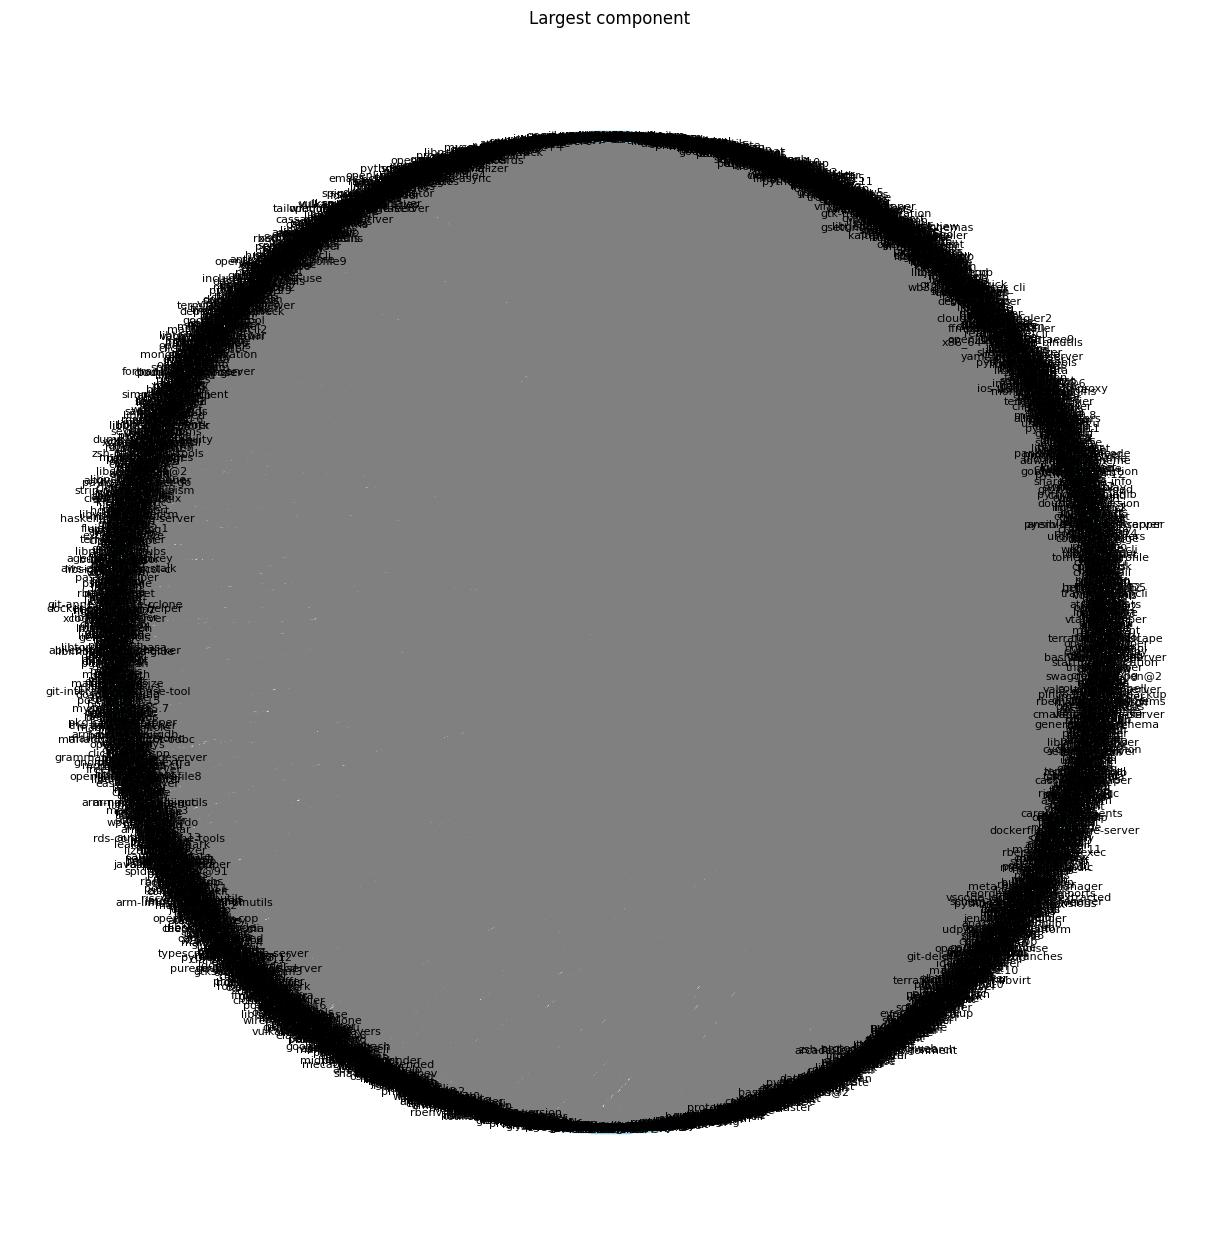

In [98]:
from networkx.drawing.nx_agraph import graphviz_layout

largest_component = max(components, key=len)

# Create a subgraph of the largest component
H = G.subgraph(largest_component)


# circular layout
pos = nx.circular_layout(H)

plt.figure(figsize=(12, 12))
nx.draw(
    H,
    pos,
    with_labels=True,
    node_size=50,
    node_color="skyblue",
    edge_color="gray",
    font_size=8,
)
plt.title("Largest component")
plt.axis("equal")
plt.show()

In [75]:
# Load package stats
stats = pd.read_csv(
    "data/csv/package_stats_with_contributors.csv",
    dtype={
        "install": "Int64",
        "install-on-request": "Int64",
        "contributors_count": "Int64",
    },
)
stats.loc[:, "repo_url"] = stats.loc[:, "repo_url"].fillna("")
stats.head()

,Unnamed: 0,package,repo_url,install,install-on-request,contributors_count
0,0,m4,,452491,5143,<NA>
1,1,falco,https://github.com/ysugimoto/falco.git,297,297,19
2,2,diesel,https://github.com/diesel-rs/diesel.git,1499,1499,333
3,3,sickle,,28,28,<NA>
4,4,libbdplus,,198,198,<NA>


In [76]:
# Associate package stats with each node.

nodes_to_remove = []  # We can't modify the graph during iteration
for node in G.nodes:
    if node not in stats["package"].values:
        print(f"{node} not found in stats")
        nodes_to_remove.append(node)
        continue
    stats_row = stats[stats["package"] == node].iloc[0]
    G.nodes[node]["install"] = stats_row["install"]
    G.nodes[node]["install_on_request"] = stats_row["install-on-request"]
    if not pd.isnull(stats_row["contributors_count"]):
        G.nodes[node]["contributors_count"] = stats_row["contributors_count"]

print(f"Removing {len(nodes_to_remove)} nodes")
G.remove_nodes_from(nodes_to_remove)

python not found in stats
pppd not found in stats
gypsy not found in stats
openssl not found in stats
Removing 4 nodes


In [77]:
def find_dependents_to_infect(package, popularity_metric="contributors_count"):
    """Finds all direct and indirect dependents of this package, sorting by the given popularity metric.

    We assume here that the package with the smallest metric (by default number of contributors)  lacks maintainers, and is therefore vulnerable to an XZ-style attack.
    """

    dependents = set()
    node = G.nodes[package]
    if popularity_metric in node:
        dependents.add((package, node[popularity_metric]))

    for dependent in G.predecessors(package):
        dependents.update(find_dependents_to_infect(dependent, popularity_metric))

    return sorted(dependents, key=lambda x: x[1])

In [78]:
find_dependents_to_infect("ruby")

[('zlib', 45), ('ruby', 782)]

In [79]:
find_dependents_to_infect("ruby", "install_on_request")

[('gperf', 2735),
 ('libxcrypt', 3954),
 ('libffi', 89130),
 ('ca-certificates', 133072),
 ('libyaml', 177380),
 ('zlib', 195611),
 ('ruby', 316037),
 ('openssl@3', 636149)]

## Number of dependencies histogram


,Package,Number of dependent packages
3,python@3.12,584
63,zlib,582
36,openssl@3,568


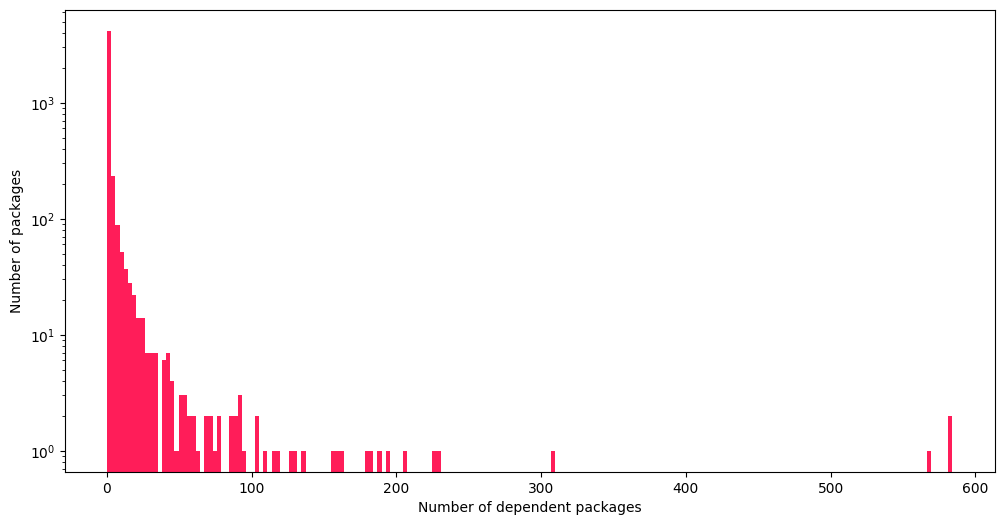

Top 10 packages by dependency count


,Package,Number of Dependencies
1236,rtabmap,307
1338,dynare,284
1340,octave,281
204,synfig,279
4192,siril,279
3819,visp,278
210,mlt,266
3181,caffe,264
1228,mxnet,260
1229,opencv,259


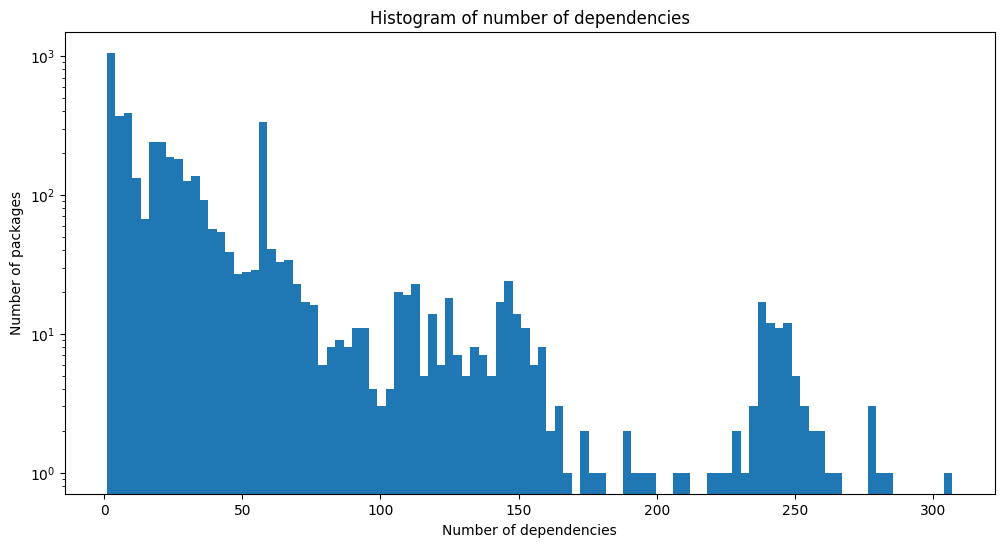

In [101]:
data_dir = Path("data")


def count_dependencies_outward_from_package(graph, package_node):
    return graph.out_degree(package_node)


def count_dependencies_reaching_package(graph, package_node):
    dependencies = set(nx.ancestors(graph, package_node))
    return len(dependencies)


def draw_dependency_dist(G):
    dependency_counts = {
        node: count_dependencies_reaching_package(G, node)
        for node in G.nodes
        if G.in_degree(node) > 0
    }

    dependency_counts_df = pd.DataFrame(
        list(dependency_counts.items()), columns=["Package", "Number of Dependencies"]
    )

    print("Top 10 packages by dependency count")
    dependency_counts_df = dependency_counts_df.sort_values(
        "Number of Dependencies", ascending=False
    )

    display(dependency_counts_df.head(10))

    # histogram of dependency count
    plt.figure(figsize=(12, 6))
    plt.hist(dependency_counts.values(), bins=100, log=True)
    plt.xlabel("Number of dependencies")
    plt.ylabel("Number of packages")
    plt.title("Histogram of number of dependencies")
    plt.show()


def draw_out_degree_dist(G):

    dependency_counts = {}
    for node in G.nodes:
        dependency_counts[node] = count_dependencies_outward_from_package(G, node)

    dependency_counts_df = pd.DataFrame(
        {
            "Package": list(dependency_counts.keys()),
            "Number of dependent packages": list(dependency_counts.values()),
        }
    )

    dependency_counts_df = dependency_counts_df.sort_values(
        "Number of dependent packages", ascending=False
    )

    display(dependency_counts_df.head(3))

    dependency_counts_df.to_csv(data_dir / "csv" / "dependency_counts.csv", index=False)

    plt.figure(figsize=(12, 6))
    plt.hist(dependency_counts.values(), bins=200, log=True, color="#ff1d59")
    plt.xlabel("Number of dependent packages")
    plt.ylabel("Number of packages")
    # plt.title("Histogram of number of dependencies")
    plt.show()


draw_out_degree_dist(G)
draw_dependency_dist(G)

# Hierarchical dependency graph for the qt package


In [99]:
import matplotlib.pyplot as plt
import networkx as nx


def graph_package_dependency(df, package):
    G = nx.from_pandas_edgelist(
        df, target="package", source="dependency", create_using=nx.DiGraph()
    )

    # Create hierarchical layout for the graph
    pos_hierarchic = nx.nx_agraph.graphviz_layout(G, prog="dot")

    # Set node colors, distinguishing the selected package
    node_colors = ["#1b0025" if node != package else "gray" for node in G.nodes()]

    # Draw nodes
    nx.draw_networkx_nodes(
        G,
        pos_hierarchic,
        node_size=50,
        node_color=node_colors,
    )

    # Draw edges with transparency
    nx.draw_networkx_edges(
        G,
        pos_hierarchic,
        edge_color="#ff1d59"
        + "80",  # Adding "80" as an example of alpha in hex (50% transparency)
    )

    # Draw labels for the specified package node
    labels = {package: package}
    nx.draw_networkx_labels(
        G, pos_hierarchic, labels=labels, font_size=12, font_color="black"
    )

    plt.tight_layout()
    plt.show()


# Example usage:
# Ensure 'df' is your DataFrame containing the dependency data
# graph_package_dependency(df, 'your_package_name_here')

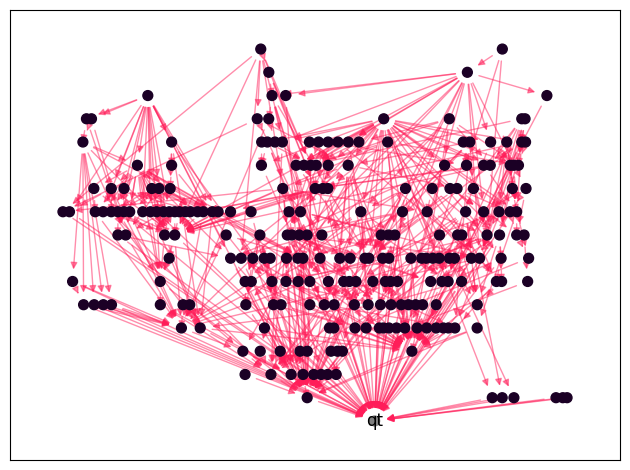

In [63]:
package_stats = pd.read_csv("data/csv/package_stats_with_contributors.csv")

df_qt = pd.read_csv("data/csv/qt.csv")
graph_package_dependency(df_qt, "qt")

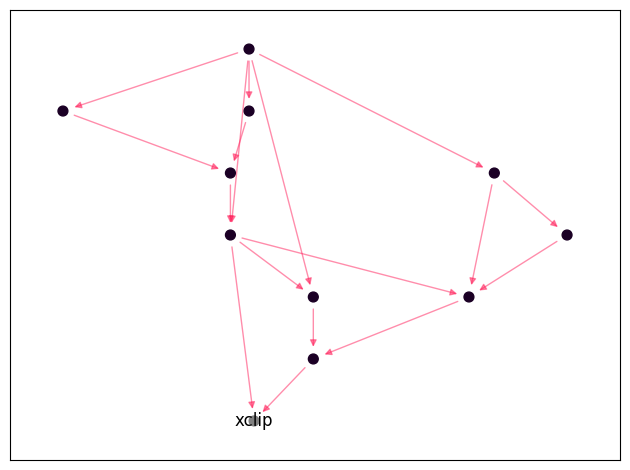

In [65]:
df_qt = pd.read_csv("data/csv/xclip.csv")
graph_package_dependency(df_qt, "xclip")

# Infection impact analysis


In [82]:
from ndlib.models.epidemics import IndependentCascadesModel
from ndlib.models import ModelConfig

SUSC, INF, REM = 0, 1, 2


def estimate_infection_fallout(first_package, infection_probability=0.5):
    model = IndependentCascadesModel(G)
    config = ModelConfig.Configuration()
    config.add_model_initial_configuration("Infected", [first_package])

    for edge in G.edges:
        config.add_edge_configuration("threshold", edge, infection_probability)

    model.set_initial_status(config)
    iterations = model.iteration_bunch(20)

    infected_packages, infected_users = 0, 0
    for iteration in iterations:
        status = iteration["status"]
        for node, node_status in status.items():
            if node_status == INF:
                infected_packages += 1
                # We can't sum installs directly, as installing a package also installs its dependencies, so some users might be counted multiple times.
                # Instead, we rely on the fact that a package is either installed or request or as a dependency
                # In the latter case, it will be counted when we analyze its dependent packages.
                infected_users += G.nodes[node]["install_on_request"]
        trends = model.build_trends(iterations)
    return trends, infected_packages, infected_users

In [84]:
_, infected_packages, infected_users = estimate_infection_fallout("ruby")
print(f"Estimated number of infected packages: {infected_packages}")
print(f"Estimated number of infected users: {infected_users}")

Estimated number of infected packages: 35
Estimated number of infected users: 990994
